In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from ewstools import core
import itertools

In [2]:
# set your path
path_from = "C:\\Users\\evely\\OneDrive\\CivilEngineeringCOVID\\week-June-22-EarlyWarning\\Seattle"
path_written_to = "C:\\Users\\evely\\OneDrive\\CivilEngineeringCOVID\\week-June-22-EarlyWarning\\Seattle"

In [3]:
cityname = "Seattle"

In [4]:
input_jan = "seattle-time-series-Jan.csv"
input_feb = "seattle-time-series-Feb.csv"
input_mar = "seattle-time-series-Mar.csv"

In [5]:
# first case, death, shelter in place

first_case = "Jan. 21st"
first_death = "Feb. 29th"
shelter = "Mar. 23rd"

# start from zero, since the graph has zero
case_num = 21 - 1
death_num = 31 + 29 - 1
shelter_num = 31 + 29 + 23 - 1

In [6]:
# set the starting value, ending value and step for bandwidth and rowing window
bw_start = 15
bw_end = 90
bw_step = 2
rw_start = 0.2
rw_end = 0.5
rw_step = 0.01


# move forward
span = 0.25
lags = [1] 
ews = ['sd','ac'] 

In [7]:
os.chdir(path_from)
os.getcwd()

'C:\\Users\\evely\\OneDrive\\CivilEngineeringCOVID\\week-June-22-EarlyWarning\\Seattle'

In [8]:
# read
df1 = pd.read_csv(input_jan)
print(df1.columns)

Index(['Unnamed: 0', 'Date', 'Essential', 'NonEssential'], dtype='object')


In [9]:
# drop the index column
df1 = df1.drop('Unnamed: 0',axis=1)

In [10]:
# schema of the data frame
df1

,Date,Essential,NonEssential
0,2020-01-01,6081,55477
1,2020-01-02,9515,66272
2,2020-01-03,9650,70852
3,2020-01-04,7186,63097
4,2020-01-05,6484,51725
5,2020-01-06,9892,72584
6,2020-01-07,10601,77990
7,2020-01-08,11447,82583
8,2020-01-09,11079,82644
9,2020-01-10,10898,83240


In [11]:
df2 = pd.read_csv(input_feb)
df2 = df2.drop('Unnamed: 0',axis=1)
df3 = pd.read_csv(input_mar)
df3 = df3.drop('Unnamed: 0',axis=1)
print(df2.shape)
print(df3.shape)

(29, 3)
(31, 3)


In [12]:
# combine
cityWhole = pd.concat([df1,df2,df3],ignore_index=True)
cityWhole

,Date,Essential,NonEssential
0,2020-01-01,6081,55477
1,2020-01-02,9515,66272
2,2020-01-03,9650,70852
3,2020-01-04,7186,63097
4,2020-01-05,6484,51725
...,...,...,...
86,2020-03-27,3921,20421
87,2020-03-28,3140,18007
88,2020-03-29,5786,46402
89,2020-03-30,4086,22197


In [13]:
total_days = len(cityWhole)
print(total_days)
cityWhole.index

91


RangeIndex(start=0, stop=91, step=1)

In [14]:
# create two list of possible rowing-window values and band-width values, put them into list to feed into itertools functions
rw = list(np.arange(rw_start,rw_end,rw_step))
bw = list(np.arange(bw_start,bw_end,bw_step))
list1 = [rw,bw]

In [15]:
# generate a list of tuples that contains (rowing-window-value,bandwidth-value) pairs
prod = itertools.product(*list1)
TupList = []
for i in prod:
    TupList.append(i)

In [16]:
# create 2 new lists to store all values of std and all values of lag-1AC
storage_std = np.array([])
storage_lag = np.array([])

In [17]:
# for each (rowing-window,bandwidth) pair, compute the ews dataframe, store the corresponding kendall tau value of std into storage_std, and store the corresponding kendall tau value of lag into storage_lag
for i in range(len(TupList)):
    ews_dic = core.ews_compute(cityWhole["Essential"], roll_window = TupList[i][0],smooth ='Gaussian',band_width= TupList[i][1],span = span,lag_times = [1], ews = ews,upto = 'Full')
    if i != 0: # exclude the first item since they are NoneType objects and this will make the entire array to be type "object" if include them
        storage_std = np.append(storage_std,ews_dic['Kendall tau']["Standard deviation"][0]) # pandas series with 1 element, so index 0
        storage_lag = np.append(storage_lag, ews_dic['Kendall tau']["Lag-1 AC"][0]) # pandas series with 1 element, so index 0

In [18]:
# print out the max kendall tau for std and lagAC for comparison
max_std = np.amax(storage_std)
max_lag = np.amax(storage_lag)
print(max_std)
print(max_lag)

0.6648936170212766
0.5868794326241135


In [19]:
print(len(TupList))
print(len(storage_std))
print(len(storage_lag))

1140
1139
1139


##### Add one when locating the tuple in TupList since the first item is "None Type" in tupList and we did not store that in storage_std and storage_lag

In [20]:
# find the location/index of maximum std in the storage_std, and use the index to find the corresponding rowing-window and bandwidth
print("*** max std located in pair ***")
max_std_index = np.where(storage_std == max_std)
print("index at : " + str(max_std_index[0]+1) + "in TupList")
# store the tuple for comparison
target_pair_1 = TupList[max_std_index[0][0]+1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_1))
print("largest std kendall tau: " + str(max_std))

*** max std located in pair ***
index at : [1137 1138 1139]in TupList
tuple (rowing-windows,bandwidth): (0.49000000000000027, 85)
largest std kendall tau: 0.6648936170212766


In [21]:
# some mechanism to find the index of maximum lagAC and the corresponding tuple
print("*** max lag located in pair ***")
max_lag_index = np.where(storage_lag == max_lag)
print("index at : " + str(max_lag_index[0]+1) + "in TupList")
# store the tuple for comparison
target_pair_2 = TupList[max_lag_index[0][0]+1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_2))
print("largest lag kendall tau: " + str(max_lag))

*** max lag located in pair ***
index at : [1137 1138 1139]in TupList
tuple (rowing-windows,bandwidth): (0.49000000000000027, 85)
largest lag kendall tau: 0.5868794326241135


In [22]:
# create an empty tuple, the tuple that contains larger Kendall Tau value will be selected
# select either AC max tuple or Standard Deviation max tuple automatically
selected_pair = ()
if (max_lag > max_std):
    selected_pair = target_pair_2
    print("lagAC larger, select " + str(target_pair_2))
elif(max_lag < max_std):
    selected_pair = target_pair_1
    print("std larger, select " + str(target_pair_1))
else:
    print("rare case!")
    selected_pair = target_pair_2

std larger, select (0.49000000000000027, 85)


In [23]:
# double check, print out
setRW = selected_pair[0]
setBW = selected_pair[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic = core.ews_compute(cityWhole["Essential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.49000000000000027
setBW : 85


In [24]:
# dfs
df_ews = ews_dic['EWS metrics']
df_ktau = ews_dic['Kendall tau']

In [25]:
# different cities needs adjustment of the location of annotation since total number varies
# set to mean, so location set automatically

# location of annotation for the 1st graph
annotation_location_1 = np.mean(df_ews[["State variable"]])
annotation_location_2 = np.mean(df_ews[["Residuals"]])
# location of annotations for the 2nd graph
annotation_location_3 = np.mean(df_ews["Standard deviation"])
# location of annotations for the 3rd graph
annotation_location_4 = np.mean(df_ews["Lag-1 AC"])

In [26]:
# 2 parameter: you may want to change these two
LegendTF = False
generateNow = False

# set the early warning (gray)band using the variables below 

# Action Required: the start and the end of band in first graph
bar_start_1 = 56 # need modification
bar_end_1 = 58 # need modification


# Action Required: the start and the end of band in 2nd graph
bar_start_2 = 78 # need modification
bar_end_2 = 80 # need modification


# Action Required: the start and the end of band in 3rd graph
bar_start_3 = 56 # need modification
bar_end_3 = 58 # need modification

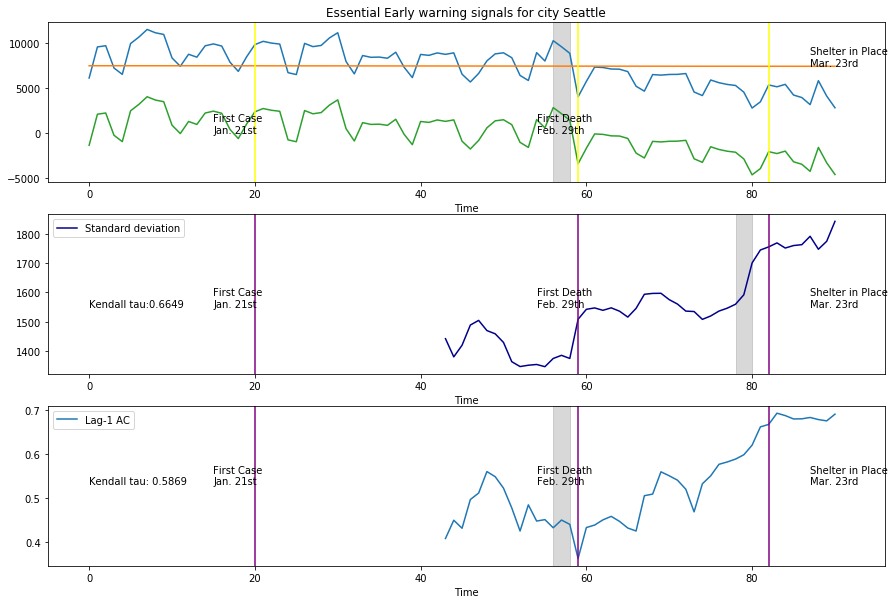

In [27]:
# the dates and string of first case, first death , shelter in place order are set at the beginning in the notebook
# parameter needs to be set are in the previous cell


# constant, you don't need to change them, but if you want to you can change ALPHA OR DIST 
ALPHA = 0.3
DIST = 5
ZERO = 0
NROWS = 3
NCOLS = 1

# No action require below
fig1, axes = plt.subplots(nrows = NROWS, ncols = NCOLS, figsize=(15,10))
df_ews[['State variable','Smoothing', 'Residuals']].plot(ax=axes[0],
          title = ("Essential Early warning signals for city " + cityname) , xlim = (-DIST,total_days + DIST),legend = LegendTF) # frame auto set
axes[0].axvline(x = case_num, color='yellow')
axes[0].axvline(x = death_num, color='yellow')
axes[0].axvline(x = shelter_num, color='yellow')
axes[0].annotate('First Case' +'\n'+ first_case, xy=((case_num - DIST), annotation_location_2)) # location auto set
axes[0].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_2)) # location auto set
axes[0].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_1)) # location auto set
axes[0].axvspan(bar_start_1, bar_end_1, alpha=ALPHA, color='gray')


df_ews['Standard deviation'].plot(ax=axes[1],legend=True, xlim = (-DIST,total_days+DIST),color="darkblue") # frame auto set
axes[1].axvline(x = case_num, color='purple')
axes[1].axvline(x = death_num, color='purple')
axes[1].axvline(x = shelter_num, color='purple')
axes[1].annotate("Kendall tau:" + str(round(df_ktau["Standard deviation"][0],4)), xy=(ZERO, annotation_location_3)) # location auto set
axes[1].annotate('First Case' +'\n'+ first_case, xy=((case_num - DIST), annotation_location_3)) # location auto set
axes[1].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_3)) # location auto set
axes[1].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_3)) # location auto set
axes[1].axvspan(bar_start_2, bar_end_2, alpha = ALPHA, color='gray')


df_ews[['Lag-1 AC']].plot(ax=axes[2],legend=True, xlim = (-DIST,total_days+DIST)) # frame auto set
axes[2].axvline(x = case_num, color='purple')
axes[2].axvline(x = death_num, color='purple')
axes[2].axvline(x = shelter_num, color='purple')
axes[2].annotate("Kendall tau: " + str(round(df_ktau["Lag-1 AC"][0],4)),xy=(ZERO, annotation_location_4)) # location auto set

axes[2].annotate('First Case' +'\n'+ first_case, xy=((case_num - DIST), annotation_location_4)) # location auto set
axes[2].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_4)) # location auto set
axes[2].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_4)) # location auto set
axes[2].axvspan(bar_start_3, bar_end_3, alpha = ALPHA, color='gray') 

foo_fig = plt.gcf()

# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-Essential.png"))

In [28]:
df_ktau

,Lag-1 AC,Standard deviation
0,0.586879,0.664894


In [29]:
# reset storage
storage_std = np.array([])
storage_lag = np.array([])
print("should print out two empty brakets below")
print(storage_std)
print(storage_lag)

for i in range(len(TupList)):
    ews_dic = core.ews_compute(cityWhole["NonEssential"], roll_window = TupList[i][0],smooth ='Gaussian',band_width= TupList[i][1],span = span,lag_times = [1], ews = ews,upto = 'Full')
    if i != 0:
        storage_std = np.append( storage_std,ews_dic['Kendall tau']["Standard deviation"][0])
        storage_lag = np.append(storage_lag, ews_dic['Kendall tau']["Lag-1 AC"][0])

should print out two empty brakets below
[]
[]


### I know they can be overriden, but just in case we reset all variables

In [30]:
max_std = -100000000
max_lag = -100000000
max_std = np.amax(storage_std)
max_lag = np.amax(storage_lag)
print(max_std)
print(max_lag)

0.8180272108843536
0.6719858156028369


In [31]:
print(len(TupList))
print(len(storage_std))
print(len(storage_lag))

1140
1139
1139


PLUS 1 SINCE LENGTH IS DIFFERENT

In [32]:
# reset
max_std_index = -10000000
target_pair_1 = (-10000000,-100000000)
# compute
print("*** max std located in pair ***")
max_std_index = np.where(storage_std == max_std) # find the largest element index
print("index at : " + str(max_std_index[0] + 1))
target_pair_1 = TupList[max_std_index[0][0] + 1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_1))
print("largest std kendall tau: " + str(max_std))

*** max std located in pair ***
index at : [1097 1098 1099 1100 1101]
tuple (rowing-windows,bandwidth): (0.48000000000000026, 81)
largest std kendall tau: 0.8180272108843536


In [33]:
# reset
max_lag_index = -1000000000
target_pair_2 = (-1000000000,-1000000000)
# compute
print("*** max lag located in pair ***")
max_lag_index = np.where(storage_lag == max_lag)
print("index at : " + str(max_lag_index[0] + 1)) # set to the index zero when multiple results return because we try to have smaller rowing window
target_pair_2 = TupList[max_lag_index[0][0] + 1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_2))
print("largest lag kendall tau: " + str(max_lag))

*** max lag located in pair ***
index at : [1137 1138 1139]
tuple (rowing-windows,bandwidth): (0.49000000000000027, 85)
largest lag kendall tau: 0.6719858156028369


In [34]:
selected_pair = ()
if (max_lag > max_std):
    selected_pair = target_pair_2
    print("lagAC larger, select " + str(target_pair_2))
elif(max_lag < max_std):
    selected_pair = target_pair_1
    print("std larger, select " + str(target_pair_1))
else:
    print("rare case!")
    selected_pair = target_pair_2

std larger, select (0.48000000000000026, 81)


In [35]:
setRW = -10000000
setBW = -10000000
setRW = round(selected_pair[0],3)
setBW = selected_pair[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

setRW : 0.48
setBW : 81


In [36]:
ews_dic = core.ews_compute(cityWhole["NonEssential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width=setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

In [37]:
 #The DataFrame of EWS
df_ews = ews_dic['EWS metrics']

# The DataFrame of ktau values
df_ktau = ews_dic['Kendall tau']

In [38]:
#  reset
annotation_location_1 = -10000000
annotation_location_2 = -10000000
annotation_location_3 = -10000000
annotation_location_4 = -10000000

# location of annotations for 1st graph
annotation_location_1 = np.mean(df_ews[["State variable"]])
annotation_location_2 = np.mean(df_ews[["Residuals"]])

# location of annotations for the 2nd graph
annotation_location_3 = np.mean(df_ews["Standard deviation"])
# location of annotations for the 3rd graph
annotation_location_4 = np.mean(df_ews["Lag-1 AC"])

In [39]:
# 2 parameter: you may want to change these two
LegendTF = False
generateNow = False

# set the early warning (gray)band using the variables below 

# Action Required: the start and the end of band in first graph
bar_start_1 = 56 # need modification
bar_end_1 = 58 # need modification


# Action Required: the start and the end of band in 2nd graph
bar_start_2 = 57 # need modification
bar_end_2 = 59 # need modification


# Action Required: the start and the end of band in 3rd graph
bar_start_3 = 56 # need modification
bar_end_3 = 58 # need modification

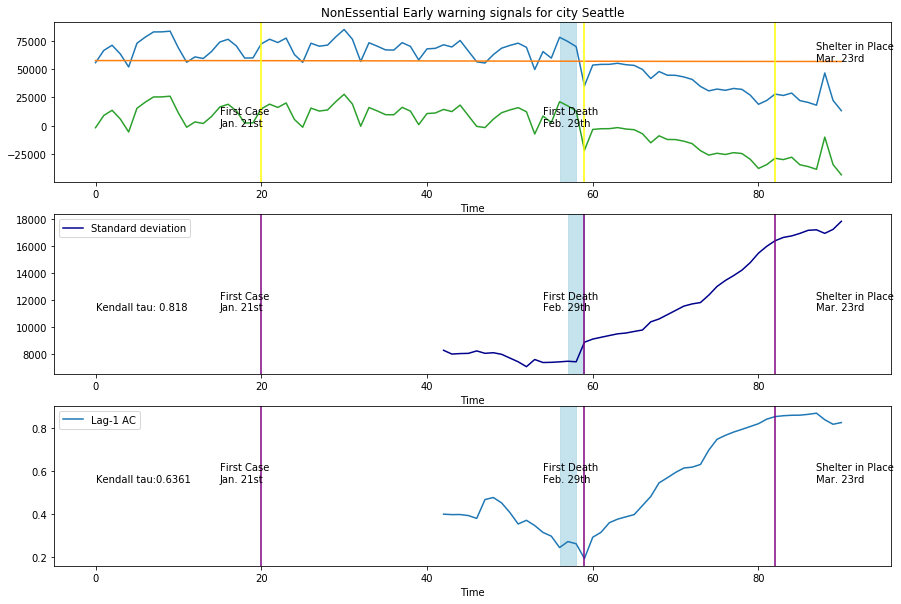

In [40]:
# the dates and string of first case, first death , shelter in place order are set at the beginning in the notebook
# parameter needs to be set are in the previous cell

# constants , you don't need to change them
ZERO = 0
DIST = 5
ALPHA = 0.7
NROWS = 3
NCOLS = 1

# plots
fig1, axes = plt.subplots(nrows = NROWS, ncols = NCOLS, figsize = (15,10))
df_ews[['State variable','Smoothing', 'Residuals']].plot(ax = axes[0],
          title = ("NonEssential Early warning signals for city " + cityname), xlim = (-DIST,(total_days + DIST)),legend = LegendTF) 
axes[0].axvline(x = case_num, color = 'yellow') # set at beginning
axes[0].axvline(x = death_num, color = 'yellow') # set at beginning
axes[0].axvline(x = shelter_num, color = 'yellow') # set at beginning
axes[0].annotate('First Case' +'\n'+ first_case, xy = (case_num - DIST, annotation_location_2)) # auto set
axes[0].annotate('First Death'+'\n'+ first_death, xy = (death_num - DIST, annotation_location_2)) # auto set
axes[0].annotate('Shelter in Place'+'\n'+ shelter, xy = (shelter_num + DIST, annotation_location_1)) # auto set
axes[0].axvspan(bar_start_1, bar_end_1, alpha = ALPHA, color='lightblue')


df_ews['Standard deviation'].plot(ax=axes[1],legend=True, xlim = (-DIST,(DIST + total_days)),color = "darkblue")
axes[1].axvline(x = case_num, color = 'purple')
axes[1].axvline(x = death_num, color = 'purple')
axes[1].axvline(x = shelter_num, color = 'purple')
axes[1].annotate("Kendall tau: " + str(round(df_ktau["Standard deviation"][0],4)), xy = (ZERO, annotation_location_3))
axes[1].annotate('First Case' +'\n'+ first_case, xy = (case_num - DIST, annotation_location_3)) # auto set
axes[1].annotate('First Death'+'\n'+ first_death, xy = (death_num - DIST, annotation_location_3)) # auto set
axes[1].annotate('Shelter in Place'+'\n'+ shelter, xy = (shelter_num + DIST, annotation_location_3)) # auto set
# need to adjust grey band manually
axes[1].axvspan(bar_start_2, bar_end_2, alpha = ALPHA, color = 'lightblue')

df_ews[['Lag-1 AC']].plot(ax=axes[2],legend=True, xlim = (-DIST,(DIST + total_days))) # auto set frame
axes[2].axvline(x = case_num, color = 'purple') # set at beginning
axes[2].axvline(x = death_num, color = 'purple') # set at beginnning
axes[2].axvline(x = shelter_num, color = 'purple') # set at beginning
axes[2].annotate("Kendall tau:" + str(round(df_ktau["Lag-1 AC"][0],4)),xy = (ZERO, annotation_location_4)) # auto
axes[2].annotate('First Case' +'\n'+ first_case, xy = (case_num - DIST, annotation_location_4)) # auto set
axes[2].annotate('First Death'+'\n'+ first_death, xy = (death_num - DIST, annotation_location_4)) # auto set
axes[2].annotate('Shelter in Place'+'\n'+ shelter, xy = (shelter_num + DIST, annotation_location_4)) # auto set
# set the grey band location manually
axes[2].axvspan(bar_start_3, bar_end_3, alpha = ALPHA, color = 'lightblue') 

foo_fig = plt.gcf()  # 'get current figure'


# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-NonEssential.png"))

In [41]:
df_ktau

,Lag-1 AC,Standard deviation
0,0.636054,0.818027
